#### Data Preprocessing

In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from keras.utils.vis_utils import plot_model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
fldr="/content/drive/MyDrive/colab/UTKFACE/UTKFace"

In [4]:
import os
files=os.listdir(fldr)
print(int(files[0].split('_')[0]))
print(files[0])

8
8_1_0_20170109202804967.jpg.chip.jpg


In [ ]:
import cv2
ages=[]
genders=[]
images=[]

for i, fle in enumerate(files):
  age=int(fle.split('_')[0])
  gender=int(fle.split('_')[1])
  total=fldr+'/'+fle
  image=cv2.imread(total)

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image= cv2.resize(image,(48,48))
  images.append(image)
  if i % 10 == 0:
    print(i)

In [69]:
for fle in files:
  age=int(fle.split('_')[0])
  gender=int(fle.split('_')[1])
  ages.append(age)
  genders.append(gender)

In [79]:
ages=ages[:23708]

In [81]:
genders=genders[:23708]

In [84]:
import numpy as np
images_f=np.array(images)
genders_f=np.array(genders)
ages_f=np.array(ages)

#np.save('/image.npy',images_f)
#np.save('/gender.npy',genders_f)
#np.save('/age.npy',ages_f)

In [12]:
#np.save('/content/drive/MyDrive/colab/models/save_age_gender_variable/image.npy',images_f)
#np.save('/content/drive/MyDrive/colab/models/save_age_gender_variable/gender.npy',genders_f)
#np.save('/content/drive/MyDrive/colab/models/save_age_gender_variable/age.npy',ages_f)

Male = 0
Female= 1

In [85]:
values, counts = np.unique(genders_f, return_counts=True)
print(counts)

[12391 11317]


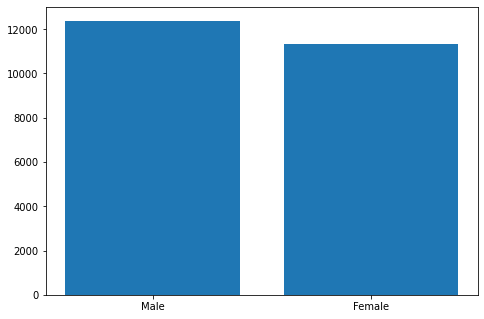

In [86]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
gender = ['Male', 'Female']
#values=[4372,5047]
ax.bar(gender,counts)#values)
plt.show()

In [ ]:
values, counts = np.unique(ages_f, return_counts=True)
print(counts)

In [15]:
#val=values.tolist()
#cnt=counts.tolist()

In [ ]:
plt.plot(counts)
plt.xlabel('ages')
plt.ylabel('distribution')
plt.show()

In [87]:
labels=[]

i=0
while i<len(ages):
  label=[]
  label.append([ages[i]])
  label.append([genders[i]])
  labels.append(label)
  i+=1

In [89]:
images_f_2=images_f/255
labels_f=np.array(labels)
images_f_2.shape

(23708, 48, 48, 3)

In [91]:
labels_f.shape

(23708, 2, 1)

In [16]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [17]:
class_label= labels_f

In [18]:
for i in range(len(labels_f)):
  index = labels_f[i][0][0]
  if index <=10:
    class_label[i][0][0] = 0
  elif index <=20:
    class_label[i][0][0] = 1
  elif index <=30:
    class_label[i][0][0] = 2
  elif index <=40:
    class_label[i][0][0] = 3
  elif index <=50:
    class_label[i][0][0] = 4
  elif index <=60:
    class_label[i][0][0] = 5
  elif index <=70:
    class_label[i][0][0] = 6
  elif index <=80:
   class_label[i][0][0] = 7
  else:
    class_label[i][0][0] = 8

In [43]:
class_age = []
for i in range(len(class_label)):
  class_age.append(class_label[i][0][0])

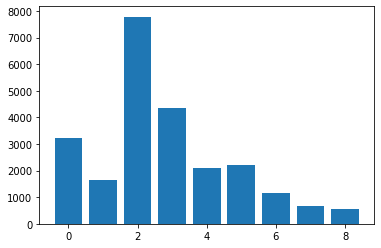

In [314]:
#Plot number of each age group
import matplotlib.pyplot as plt
from collections import Counter
class_age_pre = [np.argmax(el) for el in class_age]
# Create your list
x = class_age_pre


# Use a Counter to count the number of instances in x
c = Counter(x)

plt.bar(c.keys(), c.values())
plt.show()

In [92]:
class_age = np.array(class_age)
class_age

array([0, 0, 0, ..., 1, 1, 1])

In [149]:
class_age = to_categorical(class_age , num_classes=9)

In [154]:
class_age = np.array(class_age)

In [93]:
class_gen = []
for i in range(len(labels_f)):
  class_gen.append(labels_f[i][1][0])

In [94]:
class_gen = np.array(class_gen)

In [ ]:
class_age

In [ ]:
#for i in range(len(class_label)):
 # class_label[i][0]=np.array(class_age[i])

In [184]:
#class_gen_age = []
#for i in range(len(class_label)):
 # class_gen_age.append([class_age[i],[class_gen[i]]])

In [189]:
#X_train, X_test, Y_train, Y_test= train_test_split(images_f_2, class_gen_age,test_size=0.2)

In [213]:
#model age
X_train, X_test, Y_train, Y_test= train_test_split(images_f_2, class_age,test_size=0.2)
X_train, X_val, Y_train, Y_val= train_test_split(X_train, Y_train,test_size=0.2)

In [97]:
#model gen
X_train_g, X_test_g, Y_train_g, Y_test_g = train_test_split(images_f_2, class_gen,test_size=0.2)
X_train_g, X_val_g, Y_train_g, Y_val_g = train_test_split(X_train_g, Y_train_g,test_size=0.2)

### Model

In [98]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def Convolution(input_tensor,filters):
    
    x = Conv2D(filters=filters,kernel_size=(3, 3),padding = 'same',strides=(1, 1),kernel_regularizer=l2(0.001))(input_tensor)
    x = Dropout(0.1)(x)
    x= Activation('relu')(x)

    return x
def model(input_shape):
  inputs = Input((input_shape))
  
  conv_1= Convolution(inputs,32)
  maxp_1 = MaxPooling2D(pool_size = (2,2)) (conv_1)
  conv_2 = Convolution(maxp_1,64)
  maxp_2 = MaxPooling2D(pool_size = (2, 2)) (conv_2)
  conv_3 = Convolution(maxp_2,128)
  maxp_3 = MaxPooling2D(pool_size = (2, 2)) (conv_3)
  conv_4 = Convolution(maxp_3,256)
  maxp_4 = MaxPooling2D(pool_size = (2, 2)) (conv_4)
  flatten= Flatten() (maxp_4)
  dense_1= Dense(64,activation='relu')(flatten)
  dense_2= Dense(64,activation='relu')(flatten)
  drop_1=Dropout(0.2)(dense_1)
  drop_2=Dropout(0.2)(dense_2)
  output_1= Dense(1,activation="sigmoid",name='sex_out')(drop_1)
  output_2= Dense(1,activation="relu",name='age_out')(drop_2)
  model = Model(inputs=[inputs], outputs=[output_1,output_2])
  model.compile(loss=["binary_crossentropy","mae"], optimizer="Adam",
	metrics=["accuracy"])
  
  return model
def model1(input_shape):
  inputs = Input((input_shape))
  
  conv_1= Convolution(inputs,32)
  maxp_1 = MaxPooling2D(pool_size = (2,2)) (conv_1)
  conv_2 = Convolution(maxp_1,64)
  maxp_2 = MaxPooling2D(pool_size = (2, 2)) (conv_2)
  conv_3 = Convolution(maxp_2,128)
  maxp_3 = MaxPooling2D(pool_size = (2, 2)) (conv_3)
  conv_4 = Convolution(maxp_3,256)
  maxp_4 = MaxPooling2D(pool_size = (2, 2)) (conv_4)
  flatten= Flatten() (maxp_4)
  dense_1= Dense(64,activation='relu')(flatten)
  #dense_2= Dense(64,activation='relu')(flatten)
  drop_1=Dropout(0.2)(dense_1)
  #drop_2=Dropout(0.2)(dense_2)
  output_1= Dense(1,activation="sigmoid",name='sex_out')(drop_1)
  #output_2= Dense(9,activation="softmax",name='age_out')(drop_2)
  model = Model(inputs=[inputs], outputs=[output_1])
  model.compile(loss=["binary_crossentropy"], optimizer="Adam",
  metrics=["accuracy"])
  
  return model

def model2(input_shape):
  inputs = Input((input_shape))
  
  conv_1= Convolution(inputs,32)
  maxp_1 = MaxPooling2D(pool_size = (2,2)) (conv_1)
  conv_2 = Convolution(maxp_1,64)
  maxp_2 = MaxPooling2D(pool_size = (2, 2)) (conv_2)
  conv_3 = Convolution(maxp_2,128)
  maxp_3 = MaxPooling2D(pool_size = (2, 2)) (conv_3)
  conv_4 = Convolution(maxp_3,256)
  maxp_4 = MaxPooling2D(pool_size = (2, 2)) (conv_4)
  flatten= Flatten() (maxp_4)
  #dense_1= Dense(64,activation='relu')(flatten)
  dense_2= Dense(64,activation='relu')(flatten)
  #drop_1=Dropout(0.2)(dense_1)
  drop_2=Dropout(0.2)(dense_2)
  #output_1= Dense(1,activation="sigmoid",name='sex_out')(drop_1)
  output_2= Dense(9,activation="softmax",name='age_out')(drop_2)
  model = Model(inputs=[inputs], outputs=[output_2])
  model.compile(loss=["categorical_crossentropy"], optimizer="Adam",
  metrics=["accuracy"])
  
  return model



In [99]:
Model1 = model1((48,48,3))

In [100]:
Model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                             

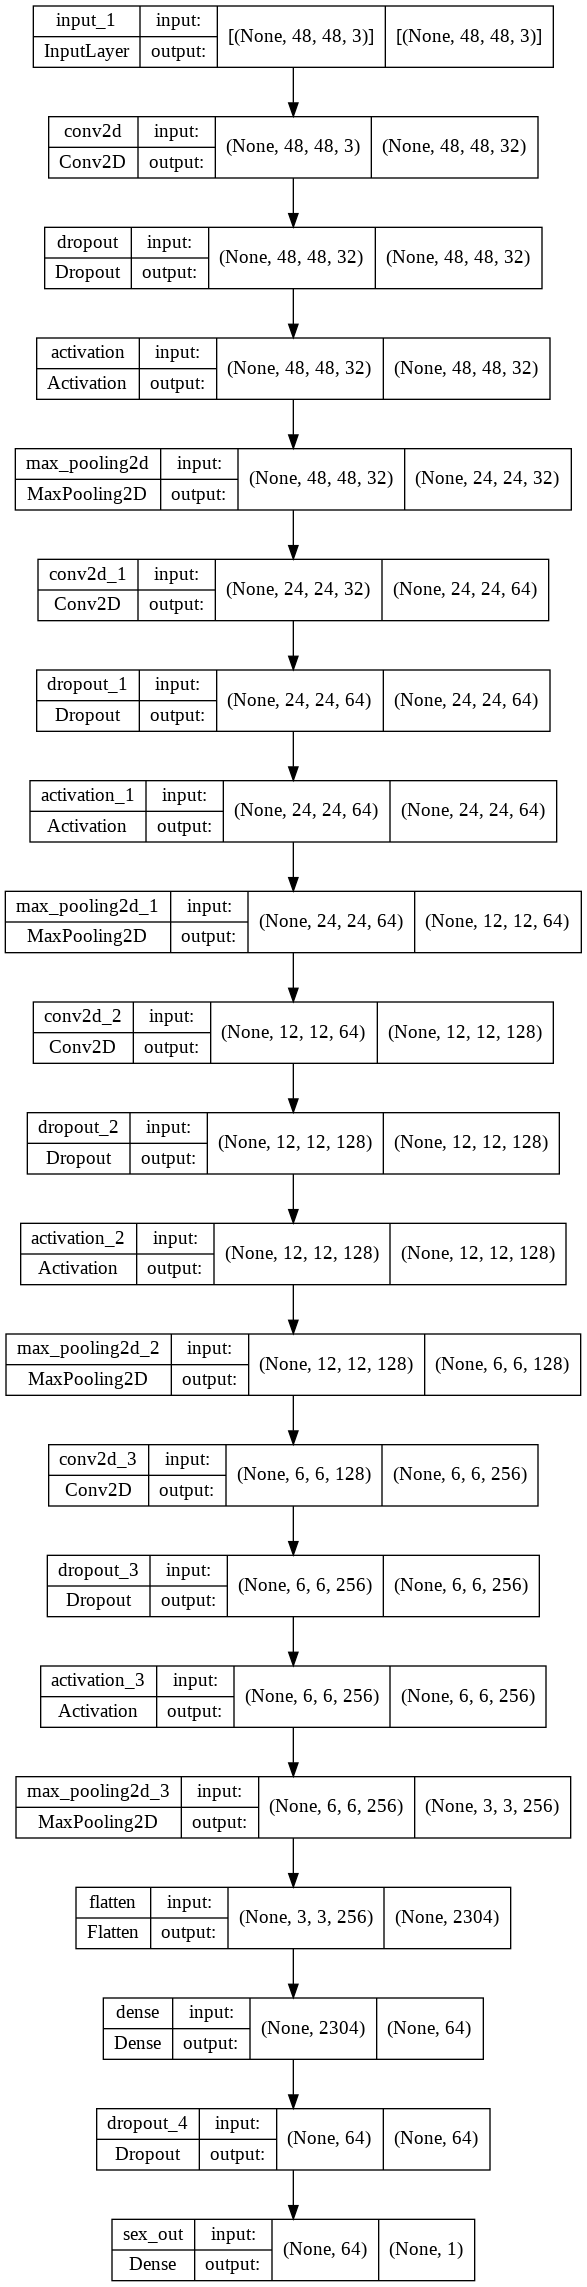

In [101]:
plot_model(Model1, to_file='model_gen.png', show_shapes=True, show_layer_names=True)

In [224]:
Model2=model2((48,48,3))

In [225]:
Model2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 dropout_34 (Dropout)        (None, 48, 48, 32)        0         
                                                                 
 activation_24 (Activation)  (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 24, 24, 64)        18496     
                                                           

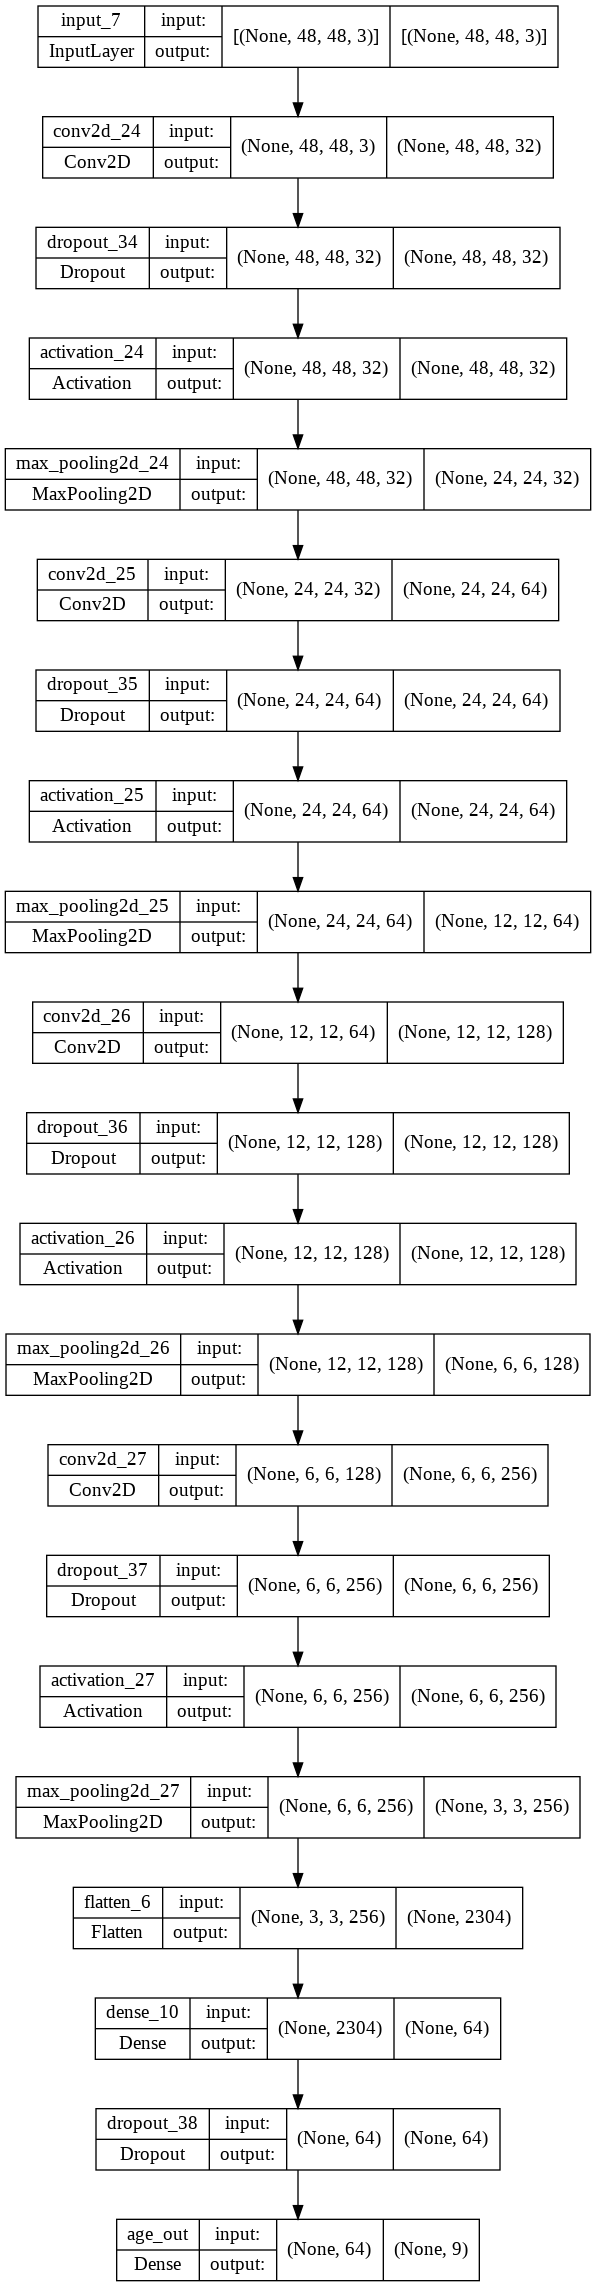

In [231]:
plot_model(Model2, to_file='model_age.png', show_shapes=True, show_layer_names=True)

#### Training

In [52]:
fle_s='Age_recognition.h5'
checkpointer = ModelCheckpoint(fle_s, monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False, mode='auto',save_freq='epoch')
Early_stop=tf.keras.callbacks.EarlyStopping(patience=75, monitor='val_loss',restore_best_weights=True),
callback_list=[checkpointer,Early_stop]

In [ ]:
History=Model.fit(X_train,Y_train_2,batch_size=64,validation_data=(X_val,Y_val_2),epochs=100,callbacks=[callback_list])

In [102]:
fle_s='Gender_recognition.h5'
checkpointer = ModelCheckpoint(fle_s, monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False, mode='auto',save_freq='epoch')
Early_stop=tf.keras.callbacks.EarlyStopping(patience=75, monitor='val_loss',restore_best_weights=True),
callback_list=[checkpointer,Early_stop]

In [103]:
History_g=Model1.fit(X_train_g,Y_train_g,batch_size=64,validation_data=(X_val_g,Y_val_g),epochs=100,callbacks=[callback_list])

Epoch 1/100
238/238 [==============================] - ETA: 0s - loss: 0.6377 - accuracy: 0.7265
Epoch 1: val_loss improved from inf to 0.55201, saving model to Gender_recognition.h5
238/238 [==============================] - 17s 16ms/step - loss: 0.6377 - accuracy: 0.7265 - val_loss: 0.5520 - val_accuracy: 0.7665
Epoch 2/100
236/238 [============================>.] - ETA: 0s - loss: 0.4242 - accuracy: 0.8410
Epoch 2: val_loss improved from 0.55201 to 0.41339, saving model to Gender_recognition.h5
238/238 [==============================] - 3s 14ms/step - loss: 0.4242 - accuracy: 0.8410 - val_loss: 0.4134 - val_accuracy: 0.8677
Epoch 3/100
235/238 [============================>.] - ETA: 0s - loss: 0.3777 - accuracy: 0.8623
Epoch 3: val_loss improved from 0.41339 to 0.35653, saving model to Gender_recognition.h5
238/238 [==============================] - 3s 13ms/step - loss: 0.3781 - accuracy: 0.8622 - val_loss: 0.3565 - val_accuracy: 0.8745
Epoch 4/100
235/238 [=========================

In [227]:
fle_s='Age_recognition.h5'
checkpointer = ModelCheckpoint(fle_s, monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False, mode='auto',save_freq='epoch')
Early_stop=tf.keras.callbacks.EarlyStopping(patience=75, monitor='val_loss',restore_best_weights=True),
callback_list=[checkpointer,Early_stop]

In [228]:
History=Model2.fit(X_train,Y_train,batch_size=64,validation_data=(X_val,Y_val),epochs=100,callbacks=[callback_list])

Epoch 1/100
237/238 [============================>.] - ETA: 0s - loss: 1.9559 - accuracy: 0.3467
Epoch 1: val_loss improved from inf to 1.80890, saving model to Age_sex_detection_group.h5
238/238 [==============================] - 119s 496ms/step - loss: 1.9557 - accuracy: 0.3468 - val_loss: 1.8089 - val_accuracy: 0.3595
Epoch 2/100
237/238 [============================>.] - ETA: 0s - loss: 1.6188 - accuracy: 0.4330
Epoch 2: val_loss improved from 1.80890 to 1.49937, saving model to Age_sex_detection_group.h5
238/238 [==============================] - 120s 504ms/step - loss: 1.6187 - accuracy: 0.4330 - val_loss: 1.4994 - val_accuracy: 0.4715
Epoch 3/100
237/238 [============================>.] - ETA: 0s - loss: 1.4765 - accuracy: 0.4737
Epoch 3: val_loss improved from 1.49937 to 1.39834, saving model to Age_sex_detection_group.h5
238/238 [==============================] - 119s 502ms/step - loss: 1.4764 - accuracy: 0.4738 - val_loss: 1.3983 - val_accuracy: 0.4902
Epoch 4/100
237/238 [==

In [104]:
Model1.save('/content/drive/MyDrive/colab/models/gen_best(48x48x3).h5')

In [229]:
Model2.save('/content/drive/MyDrive/colab/models/age_best(group10(48x48x3)).h5')

In [54]:
from tensorflow.keras.models import load_model

### Evaluation

In [105]:
Model1.evaluate(X_test_g,Y_test_g)

149/149 [==============================] - 1s 5ms/step - loss: 0.2925 - accuracy: 0.9036


[0.2925310432910919, 0.9036271572113037]

In [233]:
Model2.evaluate(X_test,Y_test)

149/149 [==============================] - 16s 109ms/step - loss: 1.2223 - accuracy: 0.5668


[1.2222977876663208, 0.566849410533905]

#Metric Gender

In [106]:
pred_gen_train=Model1.predict(X_train_g)

In [107]:
pred_gen_val=Model1.predict(X_val_g)

In [108]:
pred_gen_test=Model1.predict(X_test_g)

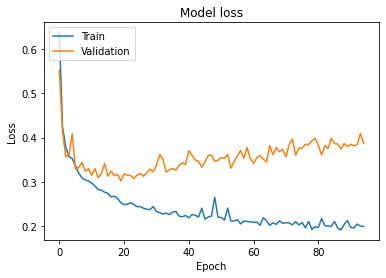

In [112]:
plt.plot(History_g.history['loss'])
plt.plot(History_g.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust()#top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,

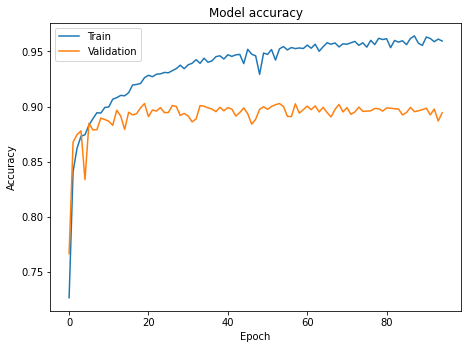

In [110]:
plt.plot(History_g.history['accuracy'])
plt.plot(History_g.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      7889
           1       0.93      0.96      0.95      7283

    accuracy                           0.95     15172
   macro avg       0.95      0.95      0.95     15172
weighted avg       0.95      0.95      0.95     15172



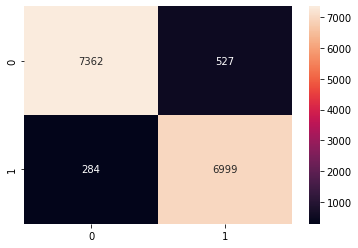

In [114]:
i=0
Pred_train_g=[]
while(i<len(pred_gen_train)):

  Pred_train_g.append(int(np.round(pred_gen_train[i])))
  i+=1
report_train_g=classification_report(Y_train_g, Pred_train_g)
print(report_train_g)
cm_train_g = confusion_matrix(Y_train_g, Pred_train_g)
sns.heatmap(cm_train_g, annot=True,fmt='')

              precision    recall  f1-score   support

           0       0.92      0.89      0.90      1973
           1       0.88      0.92      0.90      1821

    accuracy                           0.90      3794
   macro avg       0.90      0.90      0.90      3794
weighted avg       0.90      0.90      0.90      3794



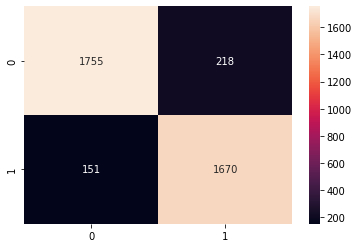

In [115]:
i=0
Pred_val_g=[]
while(i<len(pred_gen_val)):

  Pred_val_g.append(int(np.round(pred_gen_val[i])))
  i+=1
report_val_g=classification_report(Y_val_g, Pred_val_g)
print(report_val_g)
cm_val_g = confusion_matrix(Y_val_g, Pred_val_g)
sns.heatmap(cm_val_g, annot=True,fmt='')

              precision    recall  f1-score   support

           0       0.93      0.88      0.91      2529
           1       0.87      0.93      0.90      2213

    accuracy                           0.90      4742
   macro avg       0.90      0.91      0.90      4742
weighted avg       0.91      0.90      0.90      4742



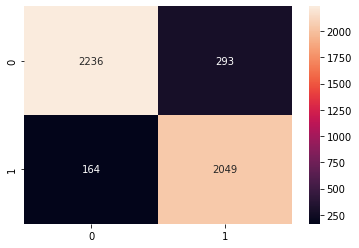

In [116]:
i=0
Pred_test_g=[]
while(i<len(pred_gen_test)):

  Pred_test_g.append(int(np.round(pred_gen_test[i])))
  i+=1
report_test_g=classification_report(Y_test_g, Pred_test_g)
print(report_test_g)
cm_test_g = confusion_matrix(Y_test_g, Pred_test_g)
sns.heatmap(cm_test_g, annot=True,fmt='')

#Metric AGE

In [240]:
pred_age_train=Model2.predict(X_train)

In [278]:
pred_age_val=Model2.predict(X_val)

In [279]:
pred_age_test=Model2.predict(X_test)

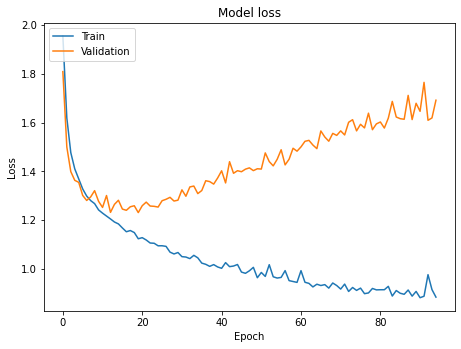

In [243]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)

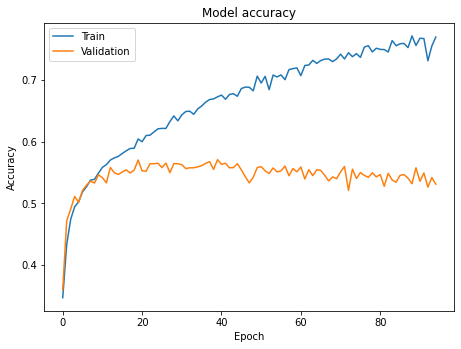

In [246]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)

### For age

In [266]:
i=0
Pred_train=[]
while(i<len(pred_age_train)):
  Pred_train.append(np.argmax(pred_age_train[i]))
  i+=1
Pred_train=np.array(Pred_train)
Y_train_check = [np.argmax(el) for el in Y_train]
report_train=classification_report(Y_train_check, Pred_train)
print(report_train)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2070
           1       0.79      0.33      0.47      1059
           2       0.68      0.93      0.78      4975
           3       0.50      0.43      0.46      2754
           4       0.53      0.20      0.29      1371
           5       0.50      0.65      0.57      1411
           6       0.41      0.29      0.34       741
           7       0.38      0.08      0.13       432
           8       0.62      0.84      0.71       359

    accuracy                           0.65     15172
   macro avg       0.59      0.52      0.52     15172
weighted avg       0.64      0.65      0.62     15172



In [283]:
cm_train = confusion_matrix(Y_train_check, Pred_train)
print('Confusion Matrix')
print(cm_train)

Confusion Matrix
[[1973   68   25    0    0    1    2    0    1]
 [  96  354  601    4    0    3    1    0    0]
 [   6   23 4636  291   10    9    0    0    0]
 [   1    1 1422 1174   84   72    0    0    0]
 [   1    2  143  646  270  299   10    0    0]
 [   1    0   34  233  128  911   92    5    7]
 [   1    0    2   22   15  417  212   29   43]
 [   0    0    2    1    0   90  171   33  135]
 [   0    0    1    0    0    4   34   20  300]]


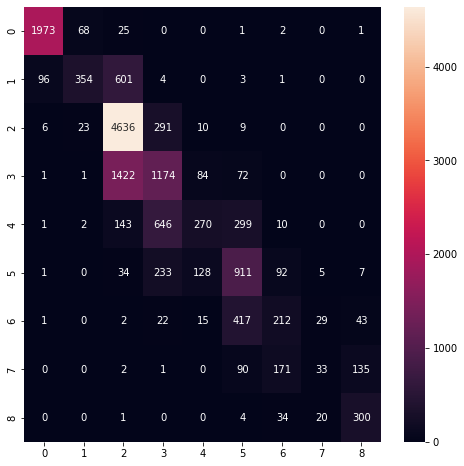

In [285]:
plt.figure(figsize=(8,8))
sns.heatmap(cm_train, annot=True,fmt="")

In [280]:
i=0
Pred_val=[]
while(i<len(pred_age_val)):
  Pred_val.append(np.argmax(pred_age_val[i]))
  i+=1
Pred_val=np.array(Pred_val)
Y_val_check = [np.argmax(el) for el in Y_val]
report_val=classification_report(Y_val_check, Pred_val)
print(report_val)

              precision    recall  f1-score   support

           0       0.88      0.89      0.89       493
           1       0.52      0.20      0.29       268
           2       0.61      0.86      0.72      1265
           3       0.40      0.32      0.36       703
           4       0.38      0.17      0.23       326
           5       0.42      0.50      0.46       347
           6       0.40      0.32      0.36       191
           7       0.50      0.07      0.12       123
           8       0.49      0.67      0.57        78

    accuracy                           0.57      3794
   macro avg       0.51      0.44      0.44      3794
weighted avg       0.55      0.57      0.54      3794



In [286]:
cm_val = confusion_matrix(Y_val_check, Pred_val)
print('Confusion Matrix')
print(cm_val)

Confusion Matrix
[[ 439   33   17    0    0    3    0    0    1]
 [  46   54  155   10    0    1    2    0    0]
 [   8   16 1094  130    6   10    1    0    0]
 [   3    1  395  227   36   39    2    0    0]
 [   0    0   82  128   55   56    4    0    1]
 [   1    0   32   65   37  173   31    2    6]
 [   1    0    9   11   10   83   61    4   12]
 [   0    0    2    2    1   40   36    8   34]
 [   1    0    1    0    0    8   14    2   52]]


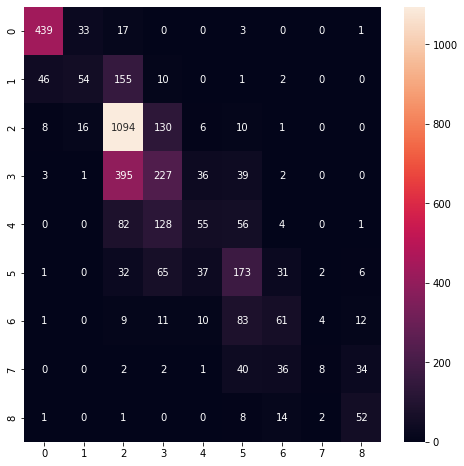

In [287]:
plt.figure(figsize=(8,8))
sns.heatmap(cm_val, annot=True,fmt="")

In [281]:
i=0
Pred_test=[]
while(i<len(pred_age_test)):
  Pred_test.append(np.argmax(pred_age_test[i]))
  i+=1
Pred_test=np.array(Pred_test)
Y_test_check = [np.argmax(el) for el in Y_test]
report_test=classification_report(Y_test_check, Pred_test)
print(report_test)

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       655
           1       0.52      0.20      0.29       332
           2       0.62      0.86      0.72      1544
           3       0.41      0.35      0.38       882
           4       0.32      0.12      0.18       403
           5       0.39      0.48      0.43       453
           6       0.34      0.24      0.28       240
           7       0.36      0.06      0.11       130
           8       0.47      0.58      0.52       103

    accuracy                           0.57      4742
   macro avg       0.48      0.42      0.42      4742
weighted avg       0.54      0.57      0.53      4742



In [292]:
tcm_test = confusion_matrix(Y_test_check, Pred_test)
print('Confusion Matrix')
print(cm_test)

Confusion Matrix
[[ 586   41   24    1    0    1    2    0    0]
 [  54   66  203    5    0    2    1    0    1]
 [   7   16 1335  163    9   12    1    0    1]
 [   3    3  472  309   37   55    2    1    0]
 [   1    0   92  160   49   97    4    0    0]
 [   0    2   35   94   53  218   41    1    9]
 [   1    0    4   21    5  126   57    8   18]
 [   0    0    1    4    2   38   39    8   38]
 [   2    0    0    0    0   17   20    4   60]]


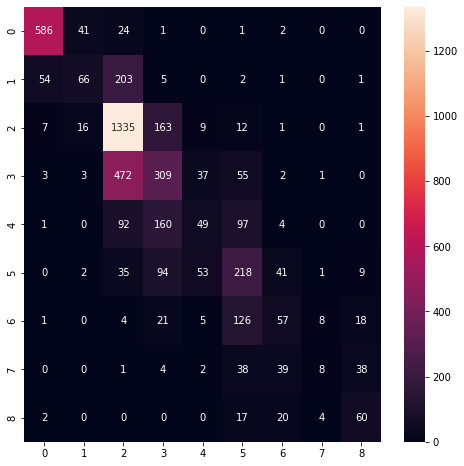

In [291]:
plt.figure(figsize=(8,8))
sns.heatmap(cm_test, annot=True,fmt="")

#### For Gender

In [58]:
i=0
Pred_train_g=[]
while(i<len(pred[0])):

  Pred_l.append(int(np.round(pred[0][i])))
  i+=1
report=classification_report(Y_test_2[0], Pred_l)
cm_train_g = confusion_matrix(Y_test_2[0], Pred_l)
sns.heatmap(results, annot=True,fmt='')

In [60]:

report=classification_report(Y_test_2[0], Pred_l)

In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      3075
           1       0.91      0.86      0.88      2852

    accuracy                           0.89      5927
   macro avg       0.89      0.89      0.89      5927
weighted avg       0.89      0.89      0.89      5927



In [61]:
print(report)

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2489
           1       0.89      0.86      0.87      2253

    accuracy                           0.88      4742
   macro avg       0.88      0.88      0.88      4742
weighted avg       0.88      0.88      0.88      4742



In [62]:

cm_train_g = confusion_matrix(Y_test_2[0], Pred_l)

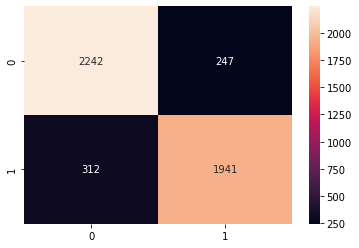

In [64]:
import seaborn as sns

sns.heatmap(results, annot=True,fmt='')

In [65]:
def test_image(ind,images_f,images_f_2,Model):
#   cv2_imshow(images_f[ind])
  plt.imshow(images_f[ind])
  image_test=images_f_2[ind]
  pred_1=Model.predict(np.array([image_test]))
  #print(pred_1)
  sex_f=['Male','Female']
  age=int(np.round(pred_1[1][0]))
  sex=int(np.round(pred_1[0][0]))
  print("Predicted Age: "+ str(age))
  print("Predicted Sex: "+ sex_f[sex])


Predicted Age: 14
Predicted Sex: Female


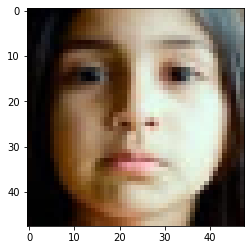

In [66]:
test_image(57,images_f,images_f_2,Model)